In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

<h2>Setup of the table for statistical analysis of scalps</h2>

drop useless columns<br />
filter wrong symbols (GOLD)<br />
sort by date<br />
calculate profit on each trade<br />

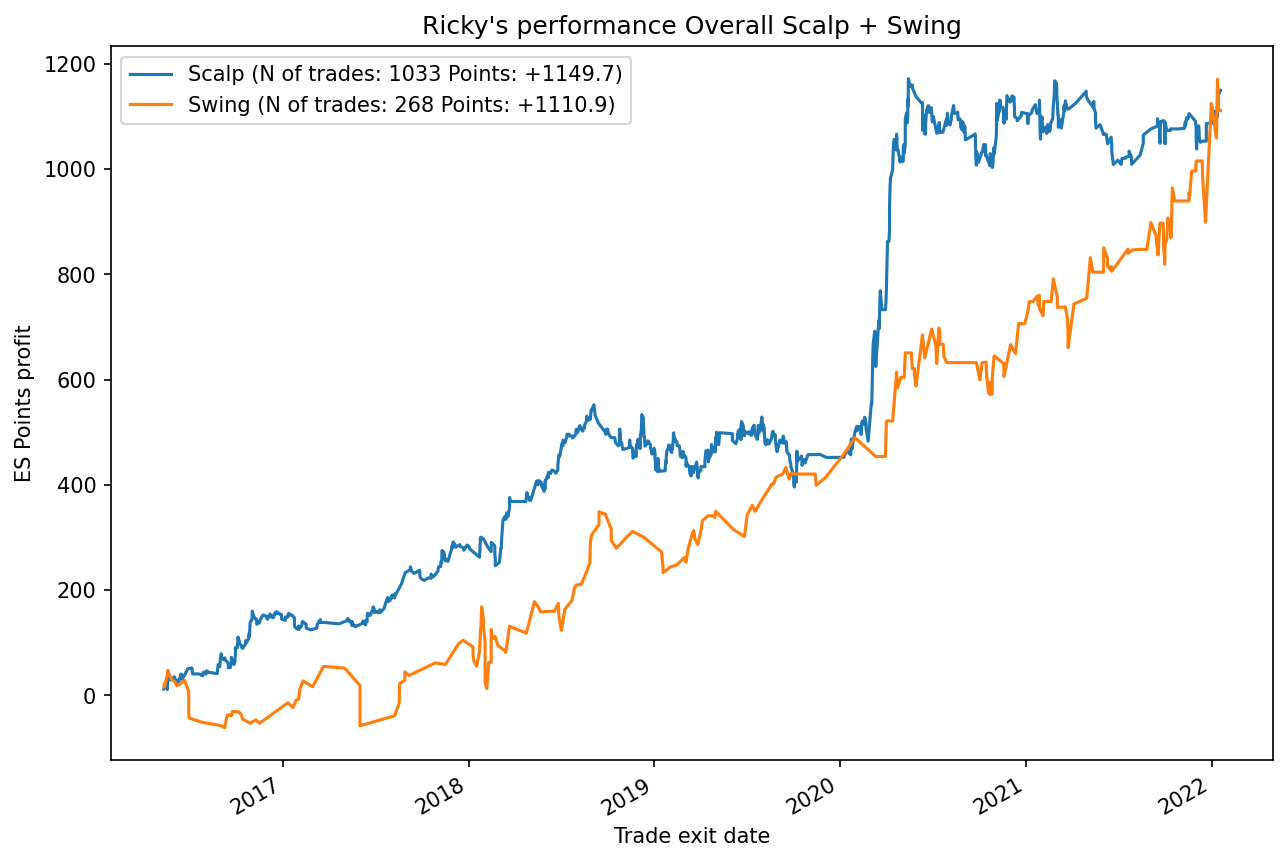

In [6]:
df = pd.read_csv('merged_trades.csv')
df = df.drop('Unnamed: 0', axis=1)
df['time_entry'] = pd.to_datetime(df['time_entry'])
df['time_exit'] = pd.to_datetime(df['time_exit'])
df = df[~df['symbol_exit'].isin(['RTY', 'GOLD'])].reset_index(drop=True)  # remove non ES trades
df = df.sort_values(by='time_exit').reset_index(drop=True)
df = df.set_index('time_exit')
def calc_profit(entry_price, exit_price, _type):
    if _type == 'short':
        return entry_price - exit_price
    elif _type == 'long':
        return exit_price - entry_price
    
    else:
        exit()
    

df['profit'] = np.vectorize(calc_profit)(df['entry_price'], df['exit_price'], df['type'])
df['profit_cumsum'] = df['profit'].cumsum()

df_scalp = df[df['timeframe'] == 'scalp'].drop('profit_cumsum', axis=1)
df_swing = df[df['timeframe'] == 'swing'].drop('profit_cumsum', axis=1)
df_scalp['profit_cumsum'] = df_scalp['profit'].cumsum()
df_swing['profit_cumsum'] = df_swing['profit'].cumsum()

# plotting of scalp + swing overall
fig, ax = plt.subplots(figsize=(10, 7), dpi=150)
df_scalp['profit_cumsum'].plot(ax=ax, label=f'Scalp (N of trades: {len(df_scalp)} Points: +{round(df_scalp["profit"].sum(), 1)})')
df_swing['profit_cumsum'].plot(ax=ax, label=f'Swing (N of trades: {len(df_swing)} Points: +{round(df_swing["profit"].sum(), 1)})')
plt.xlabel('Trade exit date')
plt.ylabel('ES Points profit')
plt.title("Ricky's performance Overall Scalp + Swing")
plt.legend();

Overall visualization

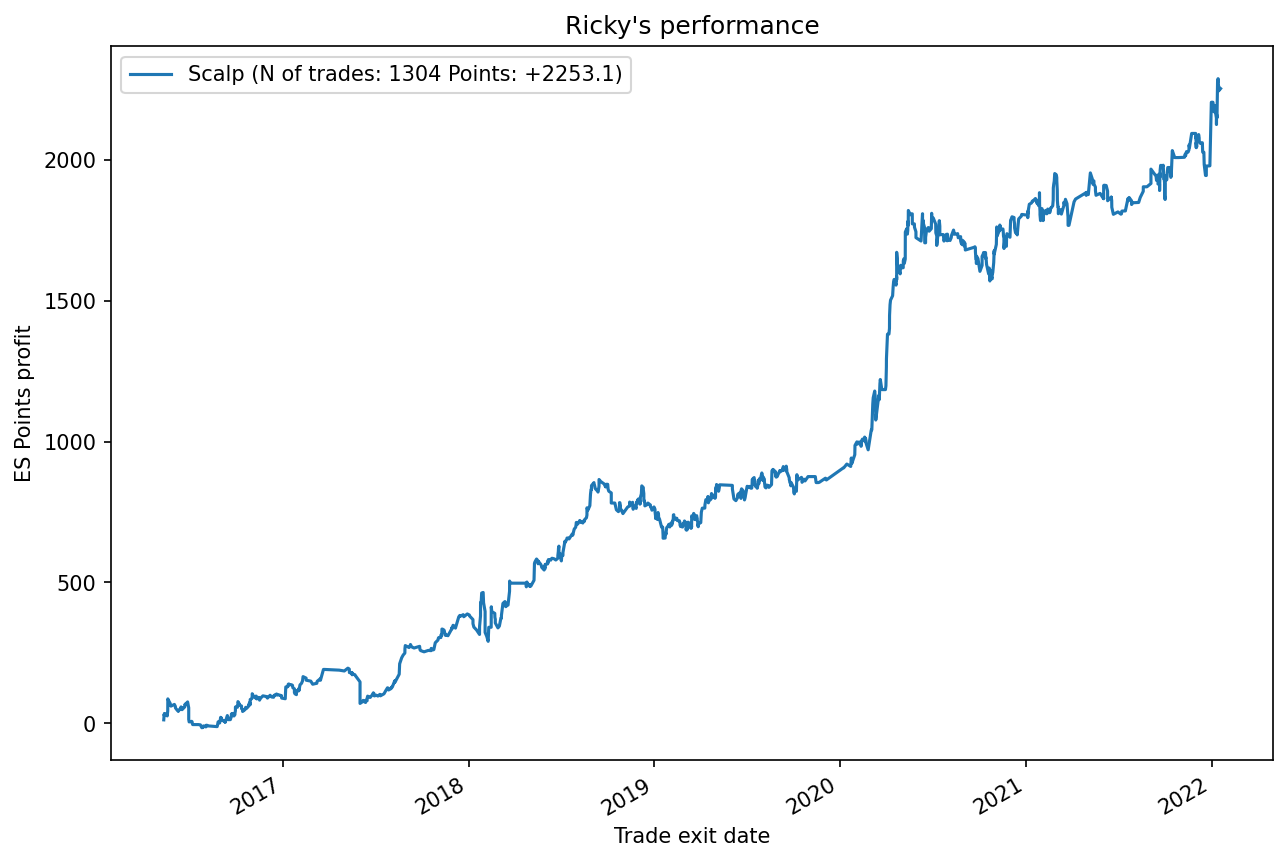

In [5]:
# plotting of YOUR data
fig, ax = plt.subplots(figsize=(10, 7), dpi=150)
df['profit_cumsum'].plot(ax=ax, label=f'Your data: (N of trades: {len(df)} Points: +{round(df["profit"].sum(), 1)})')
plt.xlabel('Trade exit date')
plt.ylabel('ES Points profit')
plt.title("Ricky's performance")
plt.legend()


<h1>Statistics based on overall profit of trades</h1>

<h2>Stats based on overall trades</h2>
1. win/loss rate<br />
2. avg point gain of trades + scatter graph<br />
3. avg win/loss when winning/losing trade<br />
<h2>Stats based on short/long</h2>
4. win/loss perc for long and short<br />
5. avg point gain for long and short<br />
<h2>Extremes</h2>
6. 10 best trades<br />
7. 10 worst trades<br />
<h2>Stats based on time (entry time)</h2>
8. Monthly profits (Jan, Feb...)<br />
9. Weekly profits (Mon, Tue..)<br />
10. Daily profits (1, 2, 3...)<br />
11. Hourly profits (10, 11, 12...)<br />

In [40]:
def calc_perc(a, b):
    return round(a / b * 100, 2)

# 1: win/loss rate
N = len(df)
win_perc = calc_perc(df[df['profit'] > 0]['profit'].count(), N)
be_perc = calc_perc(df[df['profit'] == 0]['profit'].count(), N)
loss_perc = calc_perc(df[df['profit'] < 0]['profit'].count(), N)

print('1: Win/loss rates')
print(f'Percentage of trades profitable: {win_perc}%')
print(f'Percentage of trades breakeven:  {be_perc}%')
print(f'Percentage of trades losing:     {loss_perc}%')

# 2: avg point gain stats
avg_gain_mean = round(df['profit'].mean(), 2)
avg_gain_median = round(df['profit'].median(), 2)
avg_gain_std = round(df['profit'].std(), 2)

print(f'\n2: Avg point gains per trade:')
print(f'mean:                            {avg_gain_mean} p')
print(f'median:                          {avg_gain_median} p')
print(f'standard deviation:              {avg_gain_std} p')
print(f'68% of trades are in range       {avg_gain_mean} ± {avg_gain_std} p')

# 3: avg win when winning trade / avg loss when losing trade (in points)
win_points_avg = round(df[df['profit'] > 0]['profit'].mean(), 2)
loss_points_avg = round(df[df['profit'] < 0]['profit'].mean(), 2)

print(f'\n3: Avg point gains/losses when winning/losing trade:')
print(f'winning trade:                   {win_points_avg} p')
print(f'losing trade:                    {loss_points_avg} p')

1: Win/loss rates
Percentage of trades profitable: 41.61%
Percentage of trades breakeven:  10.18%
Percentage of trades losing:     48.21%

2: Avg point gains per trade:
mean:                            1.1 p
median:                          0.0 p
standard deviation:              11.64 p
68% of trades are in range       1.1 ± 11.64 p

3: Avg point gains/losses when winning/losing trade:
winning trade:                   10.86 p
losing trade:                    -7.09 p


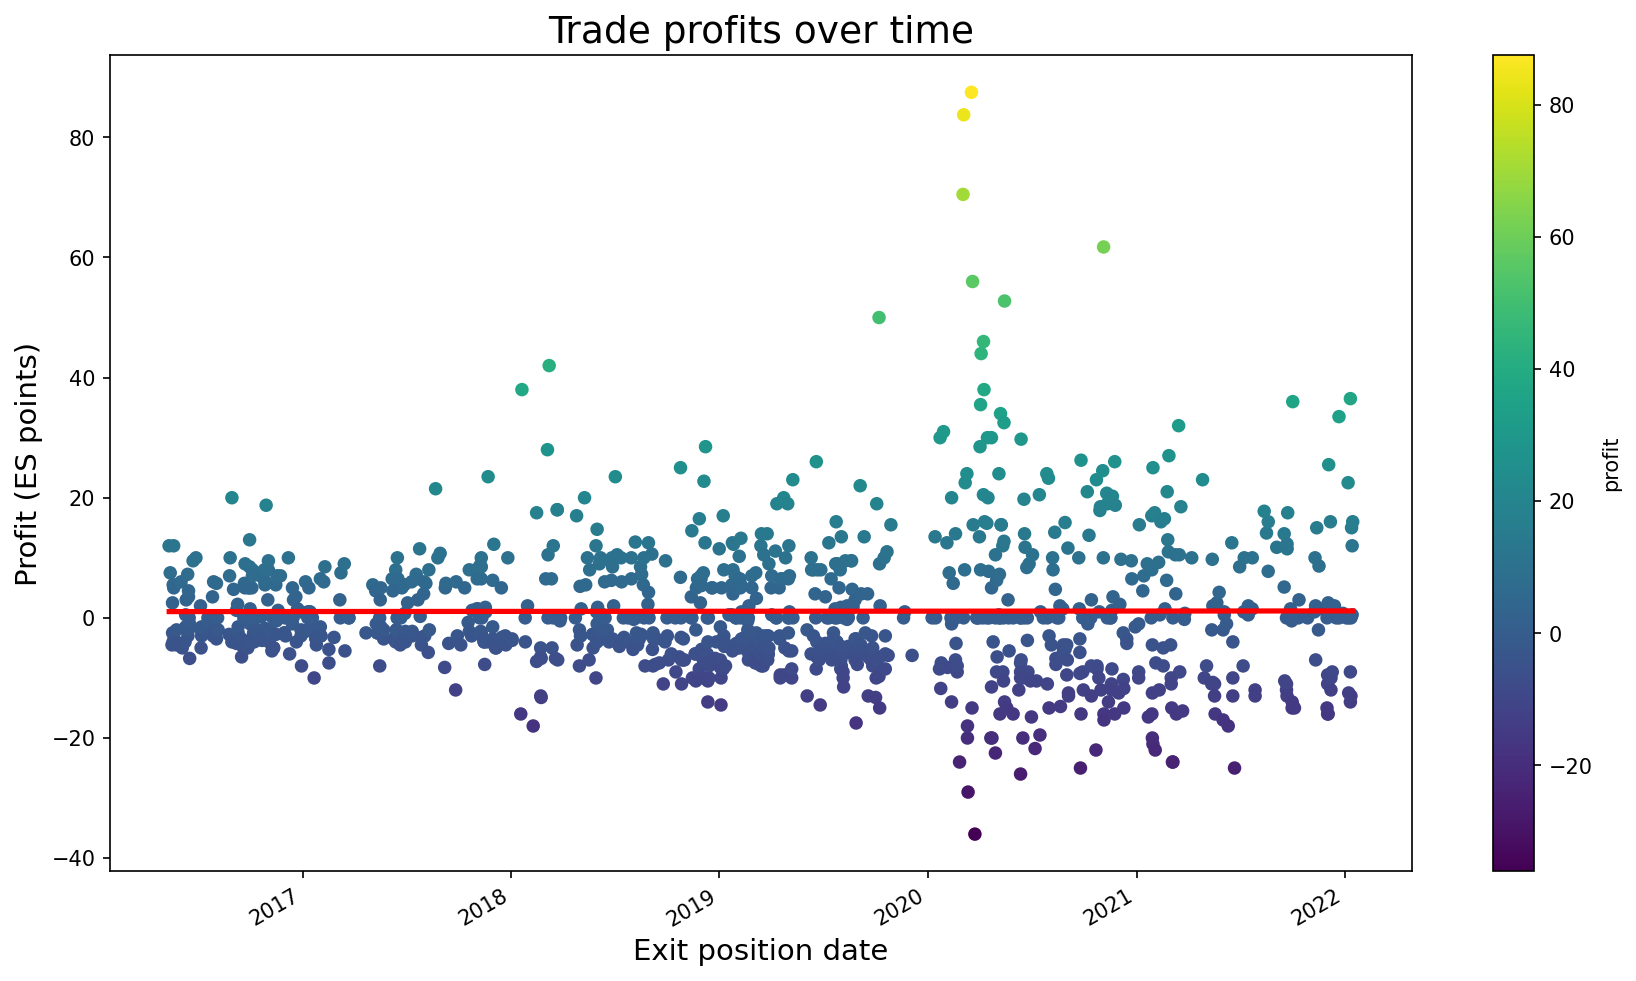

In [105]:
fig, ax = plt.subplots(figsize=(14, 8), dpi=150)
df['ordinal_time'] = df.index.map(lambda x: x.toordinal())
slope, intercept, r, p, std_err = stats.linregress(df['ordinal_time'], df['profit'])

def myfunc(x):
    return slope * x + intercept

df['linear_regression'] = df['ordinal'].apply(lambda x: slope * x + intercept)
df.plot.scatter(x='time_entry', y='profit', c='profit', 
                colormap='viridis', ax=ax, s=30)
df['linear_regression'].plot(ax=ax, color='red', lw=2.5)

plt.xlabel('Exit position date', fontsize=14)
plt.ylabel('Profit (ES points)', fontsize=14)
plt.title("Trade profits over time", fontsize=18);



<h2>S